# Holography Demo

Prepared by aph@sarao.ac.za using data from the SKA-MID prototype Dish, SDQM aka SKA-MPI.


                                                      As on 4/06/2024

In [1]:
%pylab inline
# A "sequential(2)" i.e. monotonic in lightness but with a kink around mid-range for emphasis.
# This seems more appropriate for showing 'devmaps' than the default offered by katholog.
CM = cm.afmhot

import numpy as np
np.float = float; np.int = int; np.complex = complex # Removed in numpy 1.20, still expected by below version of katholog

import katholog
print(katholog.__version__) # github.com/ska-sa/katholog tagged at sdqm-072020. 0.1.dev1737+head.2e19978
print(katholog.dataset.katdal.__version__)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Unable to initialise GPU for DFT
Unable to initialise CUDA GPU for DFT
Unable to initialise GPU for DFT
0.1.dev2818+master.793b193
0.23.dev1709+master.720b227


In [2]:
import sys; sys.path.append("/home/aph/work/dvs")
from dvs import hologreport
import katselib

# Usually kat-flap is contacted first for sensor data; it is offline for June 2024, so prevent timeouts
for k in katselib.SENSOR_PORTALS.keys():
    if ("kat-flap" in k):
        katselib.SENSOR_PORTALS[k] = np.inf

# Notes
## Convergence
1. For devmaps & offsets, use >=20deg in B1 & >=12deg in B2 & >=1.3deg in Ku-band.
2. The feed offset in the vertical plane seems to be very poorly defined, the other two are reliable.
3. Use flag_slew=True & gridsize=512 for all.


## xyzoffsets, flipping & other parameters
1. NO FLIPPING required. see hologreport.load_predicted() & hologreport.load_data().
2. For SKA Dish, all PREDICTED patterns are generated rel. to F0 in SKA-TEL-DSH-0000018 rev 2.
3. Measured patterns are referenced to center of aperture (point Q0 in above).for all

In [3]:
F_mr, f_eq = 5.8518, 8.507 # From SKA-TEL-DSH-0000018 rev 2

# PREDICTED patterns generated rel. to secondary focus (F0 in SKA-TEL-DSH-0000018 rev 2), shift to center on Q0
pDISHPARAMS = dict(telescope="SKA", xyzoffsets=[0.0, 1.476396+8.04, 0], xmag=-f_eq/F_mr, focallength=F_mr)

# Parameters for MEASURED patterns
# katholog x=cross-elevation=no offset,
#          y=elevation direction=el_axis_to_centre_on_main_reflector,
#          z=beam direction = az_axis_to_centre_on_main_reflector (from 316-000000-022 rev 1)
DISHPARAMS = dict(telescope="SKA", xyzoffsets=[0.0, 1.49, -3.52], xmag=-f_eq/F_mr, focallength=F_mr)

# Demonstrate PREDICTED Patterns
Show that all patterns are properly centered in aperture plane, and "up" appears up.

In [4]:
def demo_plots(amH, amV):
    """ Just some simple aperture plane plots from H & V maps. """
    axs = subplots(2,3, figsize=(14,8))[1]
    for ax,am in zip(axs, (amH,amV)):
        plt.sca(ax[0]); am.plot("amp", doclf=False)
        plt.sca(ax[1]); am.plot("dev", doclf=False)
        npdm = katholog.utilities.getdeviation(am.nopointingphasemap,am.mapsize,am.gridsize,am.wavelength,am.focallength,am.parabolaoffsetdev)
        plt.sca(ax[2]); plt.imshow(npdm, clim=(-1,1), cmap=CM, extent=[i*am.mapsize/2.0 for i in [-1,1,-1,1]], origin='lower')

Find sampling 0.065280[deg], extent 29.851618[deg]
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 5.6s
flatmode=pointingonly
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 5.6s
flatmode=pointingonly


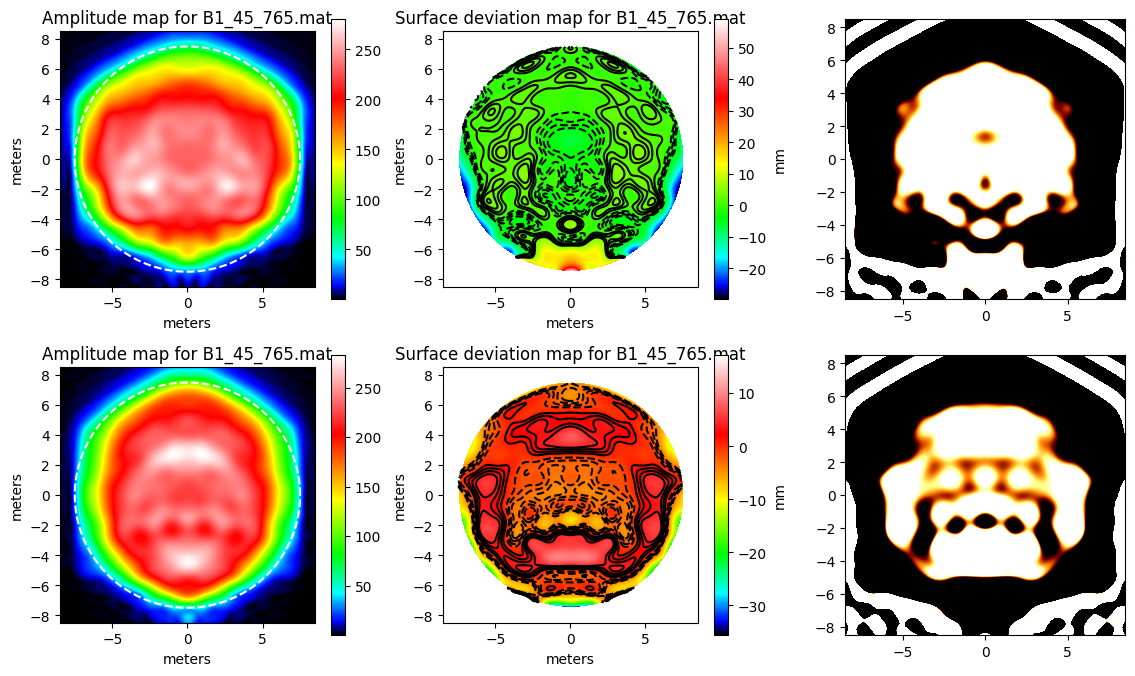

In [6]:
# B1, approximately center of band
b, amH, amV = hologreport.load_predicted(765, None, pDISHPARAMS, el_deg=45, band="B1", clipextent=30, gridsize=512)

demo_plots(amH, amV)

Find sampling 0.025816[deg], extent 11.978080[deg]
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 2.9s
flatmode=pointingonly
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 2.8s
flatmode=pointingonly


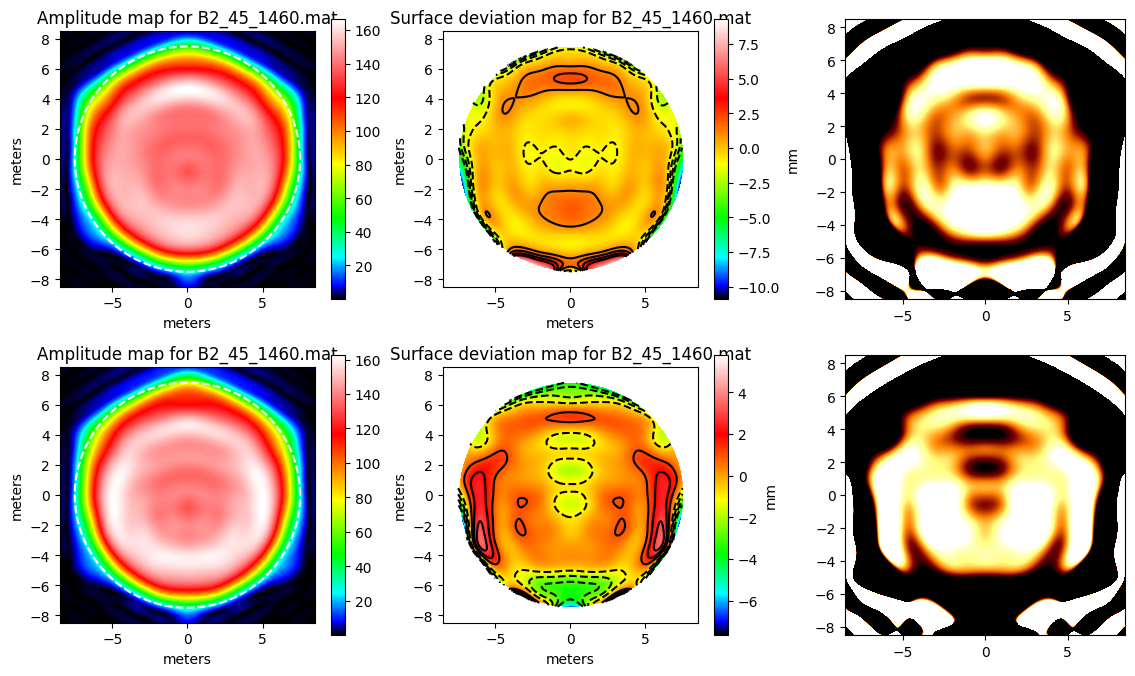

In [7]:
# B2, approximately center of band
b, amH, amV = hologreport.load_predicted(1460, None, pDISHPARAMS, el_deg=45, band="B2", clipextent=12, gridsize=512)

demo_plots(amH, amV)

Find sampling 0.004355[deg], extent 1.999898[deg]
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 17.0s
flatmode=pointingonly
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 16.9s
flatmode=pointingonly


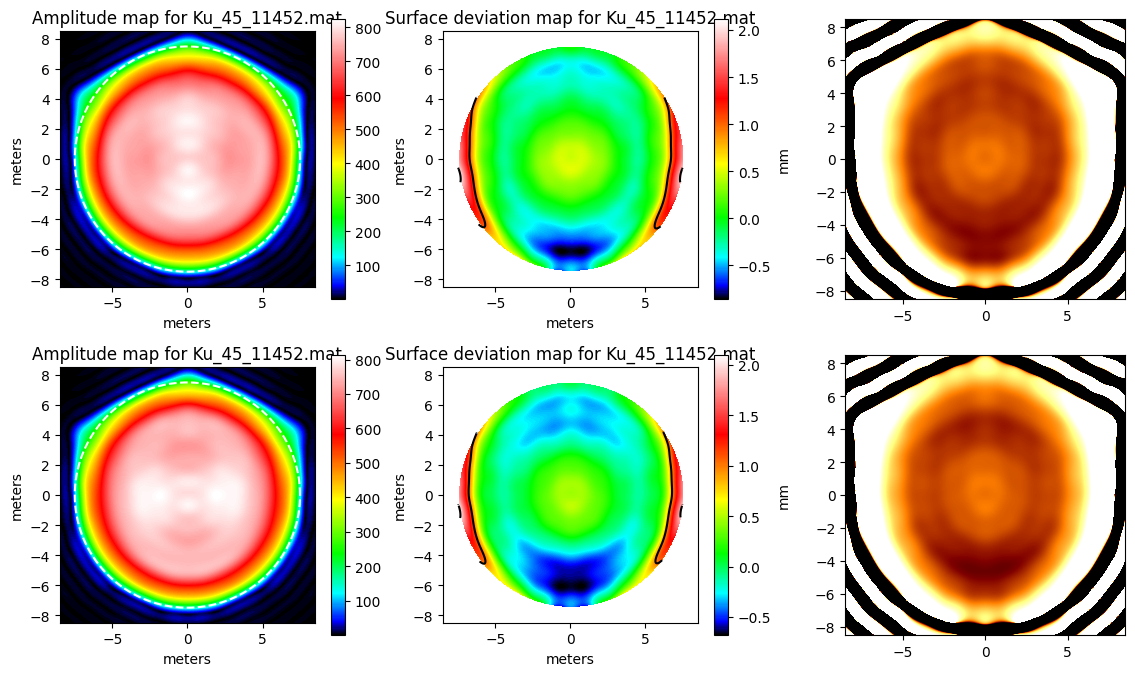

In [8]:
# Ku-band
b, amH, amV = hologreport.load_predicted(11452, None, pDISHPARAMS, el_deg=45, band="Ku", clipextent=2, gridsize=512)

demo_plots(amH, amV)

# Measured Datasets

For demonstration purposes just Ku, circular pol.

## Work-arounds for Dataset Misalignment - ONLY SKA Dishes

**When using flag_slew=True**

A well-established work-around is employed for [COMMAND_TIME_OFFSET](https://github.com/ska-sa/katproxy/blob/release/karoocamv29/katproxy/proxy/ska_mpi_dsh_model.py) (but "dirty deployment" so as [logged](http://portal.mkat-rts.karoo.kat.ac.za/katgui/sensor-graph/2021-11-01%2012:06:44/2021-11-02%2008:06:44/10,n/s0000_pos_command_time_offset)).


**2020 & 2021 Campaigns**

For data from 2020 & 2021 an additional work-around is implemented for all datasets, for pointing coordinates that appear to be misaligned from visibilities by ~0.1sec (LMC/ACU sample & hold @ 0.2sec?). All of the datasets are either unaffected or improved with this correction - most affected is Ku-band.

In [9]:
# All of the datasets in this campaign were recorded with COMMAND_LEAD_TIME = 10
katholog.dataset.katdal.visdatav4.SENSOR_PROPS['*activity']['time_offset'] = 10

# Path to local cache of datasets
filename = lambda fid: f"./demo_data/{fid}/{fid}_sdp_l0.full.rdb"

In [10]:
pred = hologreport.ResultSet("predicted", f_MHz=[11452], beacon_pol=["RCP"], clipextent=1.8)
for f,pol in zip(pred.f_MHz,pred.beacon_pol):
    b, aH, aV = hologreport.load_predicted(f, pol, pDISHPARAMS, el_deg=45, clipextent=pred.clipextent, gridsize=512)
    pred.beams.append(b); pred.apmapsH.append(aH); pred.apmapsV.append(aV)

Find sampling 0.003919[deg], extent 1.799926[deg]
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 15.1s
flatmode=pointingonly
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 15.1s
flatmode=pointingonly


In [11]:
# Position F18 in 2021, within 1mm of optimal? Pointing model not yet updated
ms_RCP = hologreport.ResultSet(1635972687,f_MHz=[11452+.2197],beacon_pol=["RCP"],clipextent=1.8,tags=["F18","night","IS ND"])
b, aH, aV = hologreport.load_data(filename(ms_RCP.fid), ms_RCP.f_MHz, "s0000", DISHPARAMS, timingoffset=0.1, flag_slew=True,
                                  clipextent=ms_RCP.clipextent, gridsize=512)
ms_RCP.beams.extend(b); ms_RCP.apmapsH.extend(aH); ms_RCP.apmapsV.extend(aV)


# Alternative to the code above, this also takes care of cycles & more
#hologreport.FID2FN[ms_RCP.fid] = filename(ms_RCP.fid)
#hologreport.load_records([ms_RCP], "s0000", timingoffset=0.1, DISHPARAMS=DISHPARAMS, gridsize=512, flag_slew=True)

Error: ./demo_data/1635972687/1635972687_sdp_l0.full.rdb is not a holography dataset
Trying anyways
Extracting timestamps
Find sampling 0.006249[deg], extent 1.778289[deg]
Flagged 95 timestamps due to slew
Find sampling 0.006249[deg], extent 1.778289[deg]
resolved using 2 channels, 0.2MHz bandwidth instead of 0.1MHz, (11452.3-11452.1)
Number of channels 2 at 11452.219700MHz within 0.210000MHz bandwidth (0.100000MHz)
Independent DIRECT calculation
using 3068 time samples and 2 channels
s0000: m028-s0000 ntime: 3068 load: 0.9 process: 0.0
Fitting done
Extracting data at 0 0 in target field (region radius 0.00011)
Detected 18 on-axis time intervals
DEBUG NOTE Time to load upfront:  0.24553871154785156
number of time samples  18  ROI used:  0.00010906510885749116
GAINRAWABS calculation
using 3068 time samples and 2 channels
s0000: m028-s0000not doing delay
 ntime: 3068 load: 0.1 process: 0.0
Starting (double) Direct Fourier Transform using 128 processes
DFT time: 3.1s
flatmode=pointingonly

Target: INTELSAT NEW DAWN
Processing tags: ['F18', 'night', 'IS ND']

-------------------- 11452.2MHz
>> 52.2 degEl @ 23.11 hrs [local time]; SNR~[[34.  6.], [34.  6.], [34.  6.], [34.  6.]]
flatmode=pointingonly
flatmode=pointingonly
SKA Feed XYZ_f offsets (feed removed) [mm]
    H-pol [0.10153159 0.56858259 0.59715444] 		V-pol [0.52139249 0.08636531 0.3894447 ]	(FI @ -22.3598 deg)
Aperture plane RMS (feed removed) [mm]:  as-is; re-collimated
              H-pol 0.21; 0.21		V-pol 0.20; 0.20
Reflector phase efficiency (feed removed):  as-is; re-collimated
    11.5 GHz: H-pol 0.989476; 0.989631		V-pol 0.991056; 0.991124
    15.0 GHz: H-pol 0.98203; 0.982297		V-pol 0.984717; 0.984835
    20.0 GHz: H-pol 0.968329; 0.968804		V-pol 0.973031; 0.973243
Error Beam
    H-pol < 5.4[0.3]% (95pct 4.4%, std 1.9%)		V-pol < 5.4[0.3]% (95pct 4.4%, std 1.9%)


/home/aph/venv-py3/lib/python3.8/site-packages/katholog/beam.py:1681: RuntimeWarning: divide by zero encountered in log10
  im=plt.imshow(20.0*np.log10(np.abs(Quant[ich,:,:])),extent=extents,cmap=self.colmap,origin='lower',vmin=clim[0],vmax=clim[1])


Report generated <bruce.science.kat.ac.za:/home/aph/work/dvs/notebooks/ku_hologreport_s0000_1635972687.pdf>


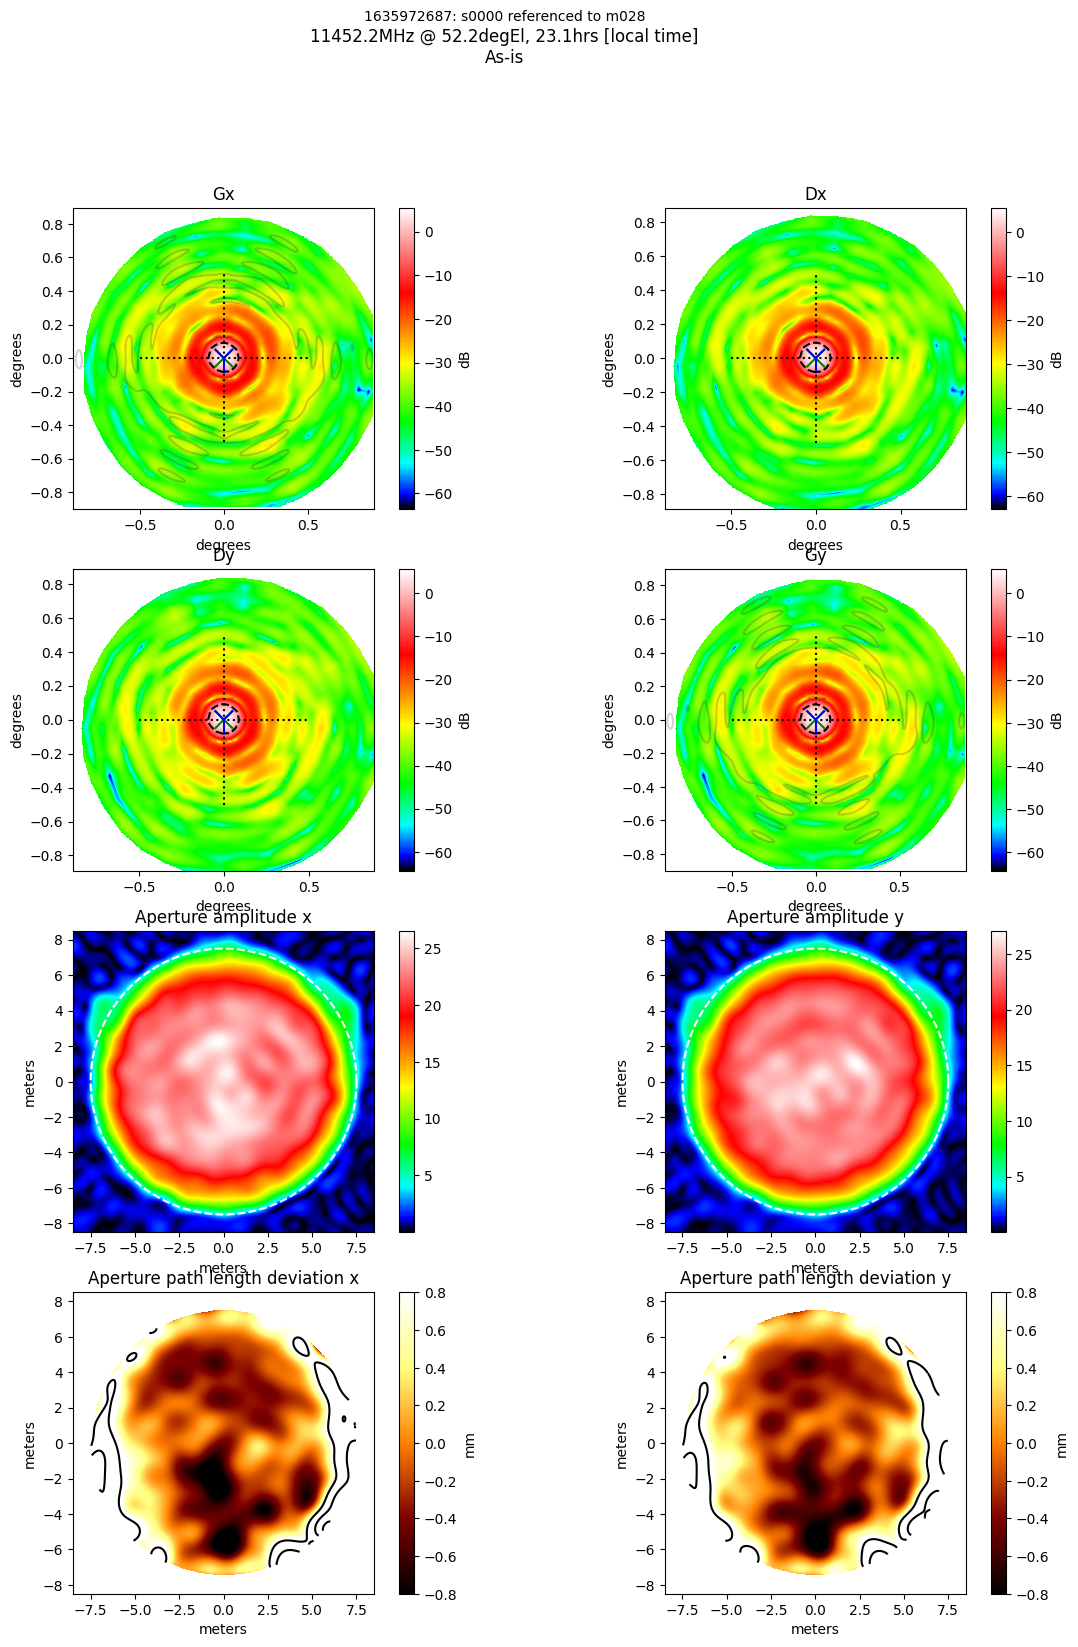

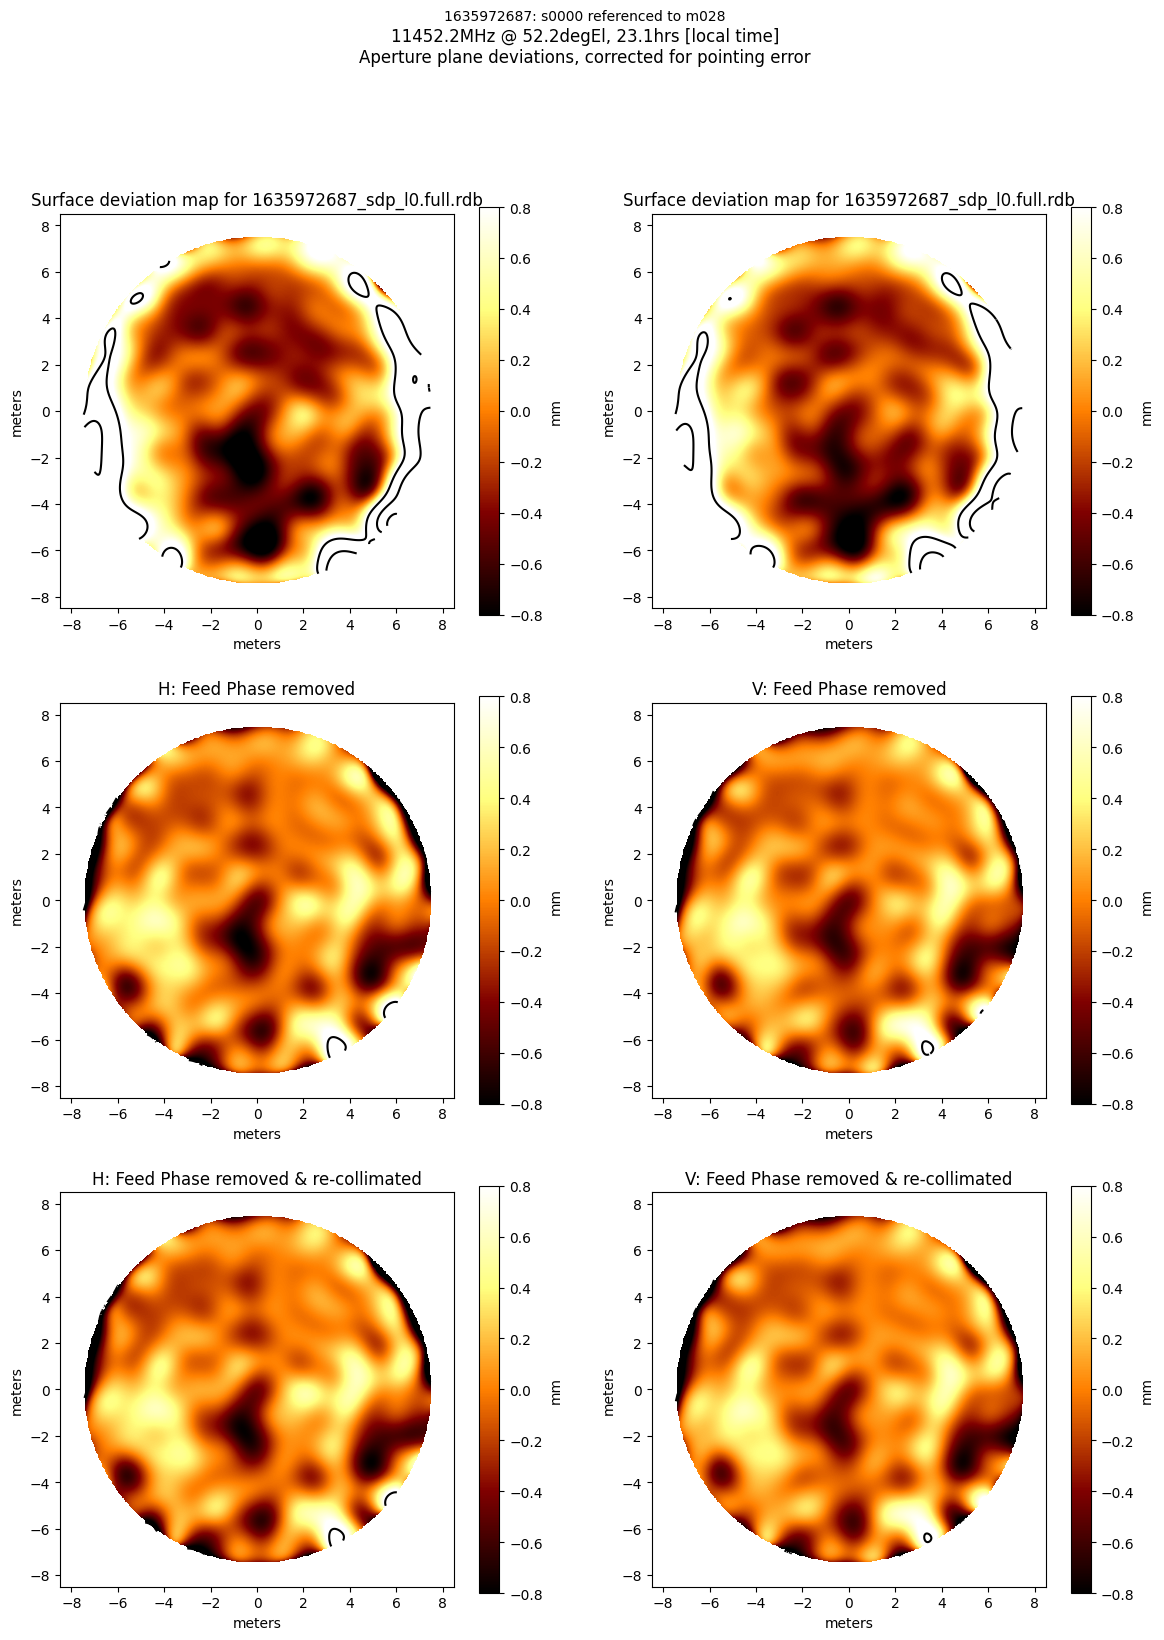

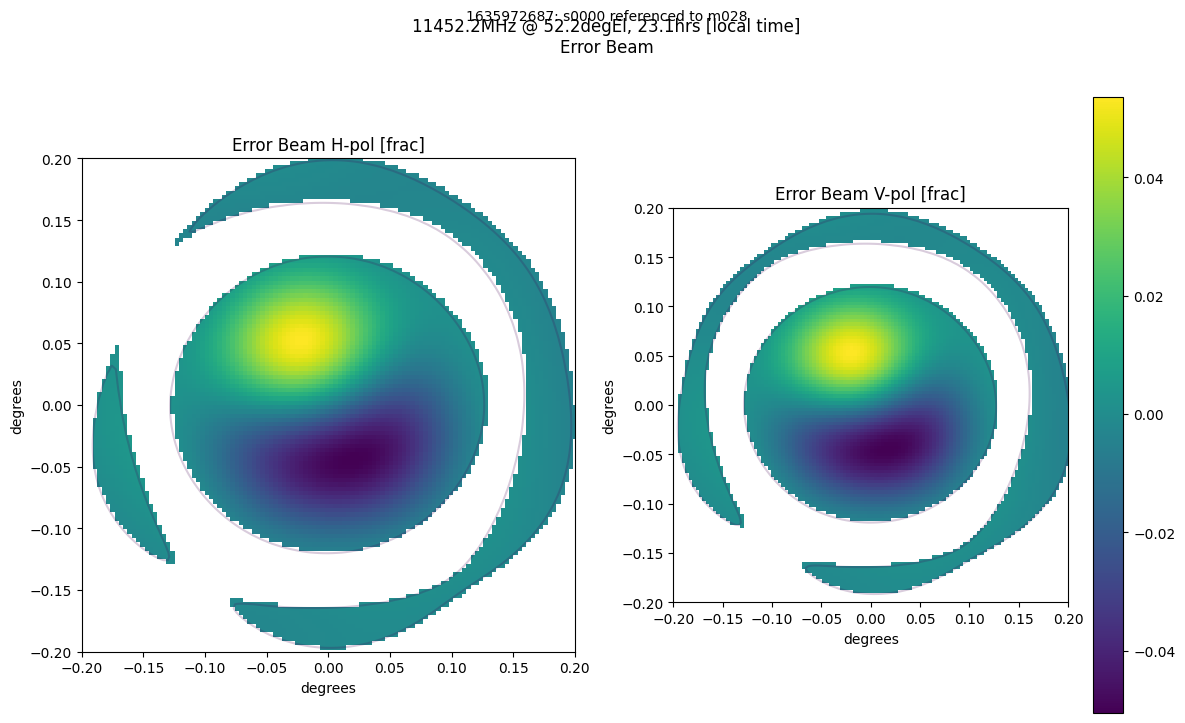

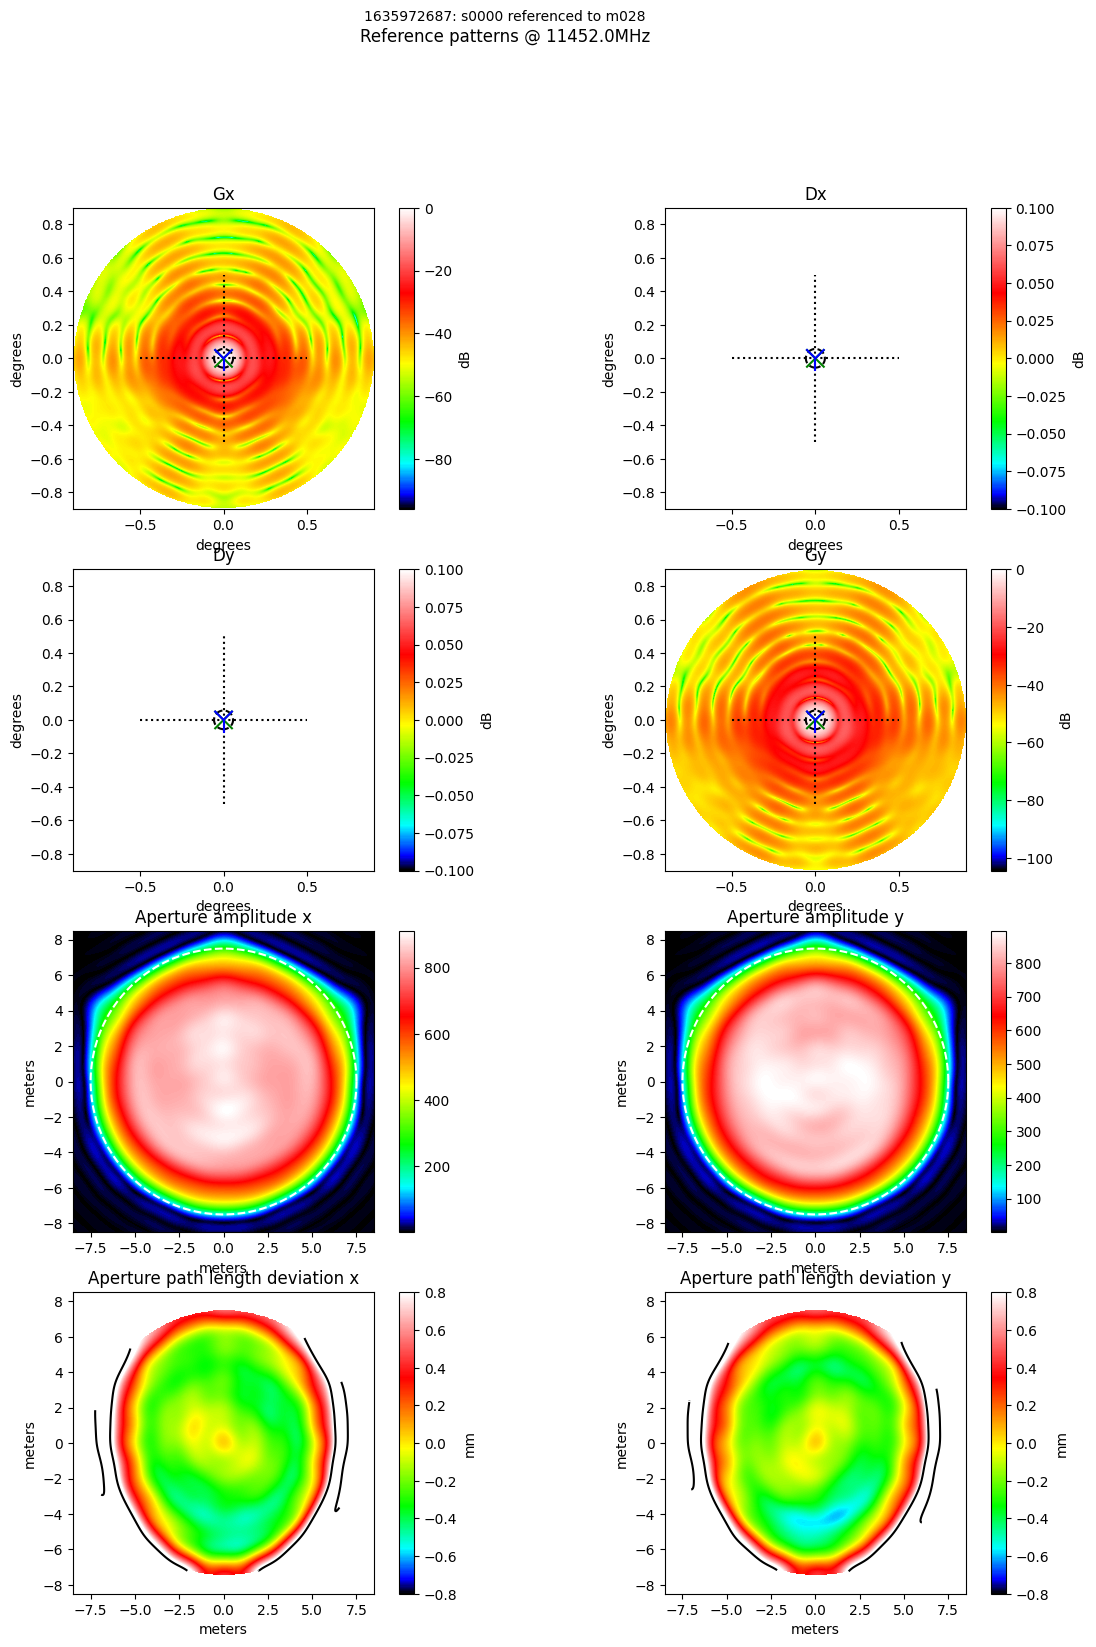

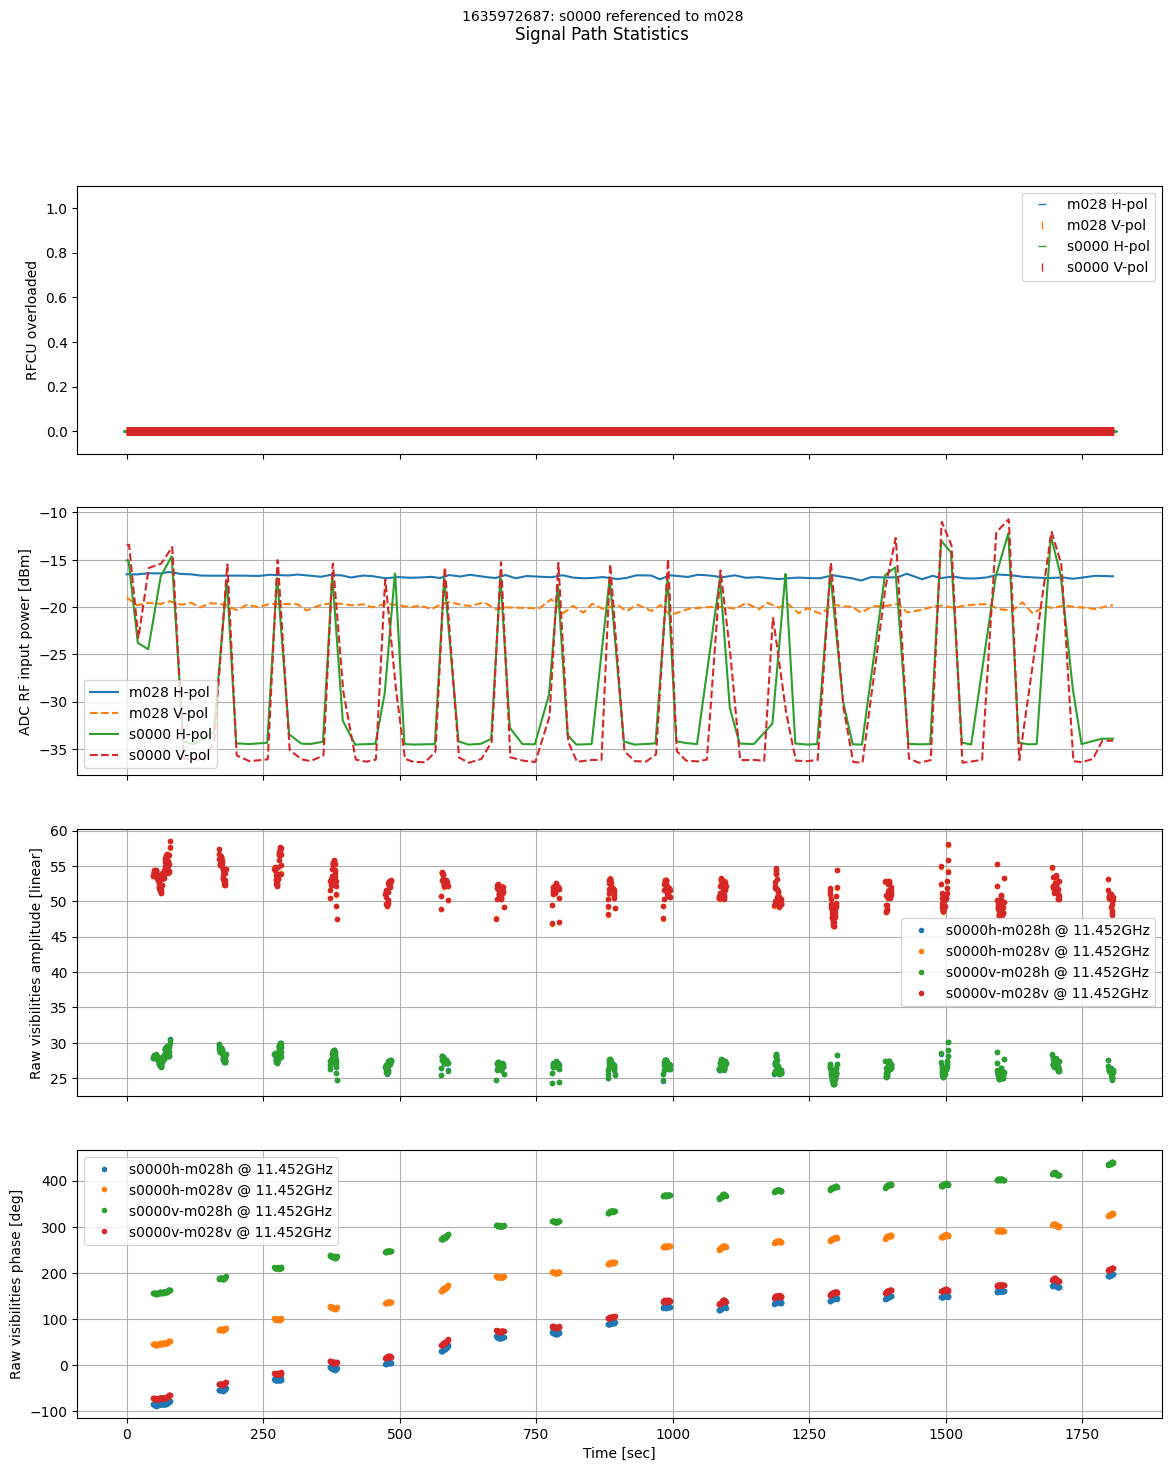

In [13]:
hologreport.generate_results(ms_RCP, pred, beampolydegree=28, beamsmoothing="zernike", SNR_min=30, cmap=CM, makepdfs=True);

### List of observations + info

In [14]:
katselib.ls_archive("Antennas:s0000 AND InstructionSet:*holography_scan* AND Description:Ku AND ExperimentID:[20211103 TO 20211104]",min_duration=1000,
                    fields=['CaptureBlockId','StartTime','Description','Targets','InstructionSet'], field_len=130);

1635913228 	2021-11-03T04:20:27Z 	SDQM: Ku-band Holography 	['azimuthunwrap', 'INTELSAT NEW DAWN'] 	/home/kat/katsdpscripts/observation/holography_scan.py --prepopulatetime 30 --scan-ants s0000 --kind radial --scan-extent 1.8 --sc
1635924315 	2021-11-03T07:25:15Z 	SDQM: Ku-band Holography 	['INTELSAT NEW DAWN', 'azimuthunwrap'] 	/home/kat/katsdpscripts/observation/holography_scan.py --prepopulatetime 30 --scan-ants s0000 --kind radial --scan-extent 1.8 --sc
1635955590 	2021-11-03T16:06:29Z 	SDQM: Ku-band Holography 	['INTELSAT NEW DAWN', 'azimuthunwrap'] 	/home/kat/katsdpscripts/observation/holography_scan.py --prepopulatetime 30 --scan-ants s0000 --kind radial --scan-extent 1.8 --sc
1635972687 	2021-11-03T20:51:26Z 	SDQM: Ku-band Holography 	['azimuthunwrap', 'INTELSAT NEW DAWN'] 	/home/kat/katsdpscripts/observation/holography_scan.py --prepopulatetime 30 --scan-ants s0000 --kind radial --scan-extent 1.8 --sc
1635974516 	2021-11-03T21:21:55Z 	SDQM: Ku-band Holography  - Spiral 	['INTE